# Data Analysis Search Results

Our analysis centered around comparing these two metrics:

\begin{align}
products_{Amazon} = \frac{N_{Amazon\ product\ slots}}{N_{product\ slots}}
\end{align}

\begin{align}
{\# 1\ spot}_{Amazon} = \frac{N_{Amazon\ \#1\ slots}}{N_{\#1\ slots}}
\end{align}

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
import glob
import time
from collections import Counter
import json
from multiprocessing import Pool

from tqdm import tqdm
from lxml import html
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
from sklearn.utils import resample

from utils import value_counts, calculate_table, calculate_table_not_unique

In [3]:
# inputs
data_dir = '../data/intermediary'
fn_search = f'{data_dir}/searches.csv.gz'
fn_products = f'{data_dir}/products_with_meta.csv.gz'
fn_queries = '../data/input/combined_queries_with_source.csv'
fn_amazon = f'{data_dir}/amazon_private_label.csv.gz'

# outputs
output_dir = '../data/output'
fn_top_searches = f'{data_dir}/top_searches.csv.gz'
fn_generic_searches = f'{data_dir}/generic_searches.csv.gz'
fig3 = f'{output_dir}/figures/fig3.png'
fig4 = f'{output_dir}/figures/fig4.png'
fig5a = f'{output_dir}/figures/fig5a.png'
fig5b = f'{output_dir}/figures/fig5b.png'
fig6a = f'{output_dir}/figures/fig6a.png'
fig6b = f'{output_dir}/figures/fig6b.png'
table1 = f'{output_dir}/tables/table1.csv'
for subdir in ['figures', 'tables']:
    os.makedirs(f'{output_dir}/{subdir}', exist_ok=True)

In [4]:
df_amazon = pd.read_csv(fn_amazon, compression='gzip')

In [5]:
df_products = pd.read_csv(fn_products, compression='gzip')
df_amazon = pd.read_csv(fn_amazon, compression='gzip')
keywords = pd.read_csv(fn_queries)

In [6]:
df_search = pd.read_csv(fn_search, compression='gzip')

In [7]:
amazon_asin = set(df_amazon.asin.tolist())
len(amazon_asin)

137420

In [8]:
# pd.DataFrame({'asin' : df_top.asin.unique()}).to_csv('../data/intermediary/top_search_asins.csv.gz', index=False, compression='gzip')

## merge data

In [8]:
_df_search = df_search[df_search.product_type.isin(['regular_placement'])]

searches_with_amazon_brands = _df_search[
    _df_search.asin.isin(amazon_asin)
].search_term.unique()
len(searches_with_amazon_brands)

4567

In [9]:
_df_search = _df_search[_df_search.search_term.isin(searches_with_amazon_brands)].merge(df_products, how='left')
_df_search['is_amazon'] = _df_search.asin.isin(amazon_asin)

In [10]:
_df_search.iloc[0]

asin                                                              B086VR2KY8
product_name               All-New Toshiba 50LF621U21 50-inch Smart 4K UH...
stars                                                                    4.6
reviews                                                                 5282
brand                                                                    NaN
product_url                /gp/slredirect/picassoRedirect.html/ref=pa_sp_...
is_prime                                                                True
is_fresh                                                               False
is_sponsored                                                           False
is_featured_brand                                                       True
is_amazons_choice                                                      False
is_best_seller                                                         False
product_order                                                              1

In [11]:
_df_search["is_shipped_by_amazon_TRUE"] = _df_search.apply(lambda x: any([x['is_shipped_by_amazon'], 
                                x['is_fresh'], x['is_prime']]), axis=1)

In [12]:
kw_generic = keywords[keywords['source'] == 'generic'].search_term
kw_seller = keywords[keywords['source'] == 'seller'].search_term
kw_autocomplete = keywords[keywords['source'].isin(
    ['autocomplete amazon', 'autocomplete walmart']
)].search_term

In [13]:
top_searches = set(kw_autocomplete.tolist() + kw_seller.tolist())
len(top_searches)

11342

In [14]:
df_top = _df_search[
    _df_search.search_term.isin(top_searches)
]
len(df_top), df_top.search_term.nunique()

(187534, 3492)

In [15]:
# how many searches had Amazon?
df_top.search_term.nunique() / len(top_searches)

0.30788220772350555

In [16]:
# how many products?
df_top.asin.nunique()

125769

In [17]:
df_top[df_top.product_order == 1].search_term.nunique()

3492

In [18]:
if not os.path.exists(fn_top_searches):
    df_top.to_csv(fn_top_searches, index=False, compression='gzip')

In [19]:
df_generic = _df_search[
   _df_search.search_term.isin(kw_generic)
]
len(df_generic), df_generic.search_term.nunique()

(69287, 1217)

In [20]:
if not os.path.exists(fn_generic_searches):
    df_generic.to_csv(fn_generic_searches, index=False, compression='gzip')

## Aggregate data

In [21]:
df = df_top

In [22]:
value_counts(df.drop_duplicates(subset=['asin']), col='is_amazon')

,count,percentage
False,119866,0.953065
True,5903,0.046935


In [23]:
# Produce plots

In [24]:
max_rank = 60
n_samples = df.search_term.nunique()
n_products = df.asin.nunique()

In [25]:
df_s = df[df.is_sponsored == True]
df_ns = df[df.is_sponsored == False]

In [26]:
n_samples_sold = df[~df.sold_by.isnull()].search_term.nunique()
n_samples_shipped = df[~df.shipped_by.isnull()].search_term.nunique()

n_products_sold = df[~df.sold_by.isnull()].asin.nunique()
n_products_shipped = df[~df.shipped_by.isnull()].asin.nunique()

In [27]:
df_amazon = df_ns[df_ns.asin.isin(amazon_asin)]
df_non_amazon = df_ns[(~df_ns.asin.isin(amazon_asin))]

df_non_amazon_non_sold_ = df_ns[(~df_ns.asin.isin(amazon_asin)) & 
                               (df_ns.is_sold_by_amazon == False) &
                               (df_ns.is_fresh == False)
                              ]


In [28]:
df_non_amazon_sold_by_amazon_ = df_ns[
        (~df_ns.asin.isin(amazon_asin)) & 
        (df_ns.is_sold_by_amazon == True)
    ]

In [29]:
df_amazon_brand_ = df_ns[df_ns.asin.isin(amazon_asin)]
df_non_amazon_brand_ = df_ns[
    ~df_ns.asin.isin(df_amazon.asin)
]

df_amazon_sold_ = df_ns[df_ns.is_sold_by_amazon == True]
df_not_amazon_sold_ = df_ns[df_ns.is_sold_by_amazon != True]

df_prime_ =  df_ns[
    (df_ns.is_prime == True) | 
    (df_ns.is_fresh == True)
]

df_non_amazon_ = df_ns[
    (~df_ns.asin.isin(amazon_asin))
  & (df_ns.is_sold_by_amazon == False)
  & (df_ns.is_shipped_by_amazon == False)
  & (df_ns.is_prime == False) 
  & (df_ns.is_fresh == False)
]

In [30]:
len(df[df.is_sponsored]) / len(df)

0.17317926349355317

In [31]:
def proportion(row):
    if row['Perc #1 spot'] > row['Perc Products']:
        val = row['Perc #1 spot'] / row['Perc Products']
        val = np.round(val, 1)
        return f"{val}x more"
    elif row['Perc #1 spot'] < row['Perc Products']:
        val = row['Perc Products'] / row['Perc #1 spot']
        val = np.round(val, 1)
        return f"{val}x less"

In [32]:
res = calculate_table_not_unique(df, amazon_asin)
res

,Category,Perc Products,Perc #1 spot,Perc first row
0,Wholly Non-Amazon,10.852965,4.553265,14.977090
1,Amazon,5.801081,19.530355,24.770905
2,Non-Amazon,76.880992,20.819015,63.516609
3,Non-Amazon Brand and Not Amazon Sold,54.902578,13.545246,46.048110
4,Amazon product not featured,4.611964,1.947308,8.218786
5,Sponsored,17.317926,59.650630,75.286369
6,Amazon sold,25.549500,20.733104,44.186712
7,Amazon sold non-Amazon,21.142300,7.016037,30.670103
8,Non-Amazon sold,57.132573,19.616266,51.718213
9,Amazon Shipped,71.672870,35.595647,70.217640


In [33]:
def bar_plots(data, figsize=(12,4)):
    cat2color = {
        'percent of all products' : 'black',
        'percent of #1 spot': 'grey'
    }
    label2label = {

    }
    colors = list(cat2color.values())

    legend_elements = [Line2D([0], [0], marker='o', color='w', 
                              label=label,
                              markerfacecolor=c, markersize=10)
                       for label, c in cat2color.items()][::-1]


    ax = data[::-1].plot(
        kind='barh',
        x='Category', y=['Perc Products', 'Perc #1 spot'],
        figsize=figsize,
        color=['black', 'grey'],
    )

    plt.title(f"What Kind of Products are on Amazon Search Pages (N={df.search_term.nunique():,})",
             x=0.48,
             y=1.05,
             size=15.5)

    ax.legend(handles=legend_elements,
          loc='lower left', 
          bbox_to_anchor= (-.01, 1.015), ncol=2,
          handletextpad=0.0,
          labelspacing=0, 
          borderaxespad=.1, 
          borderpad=0.1,
          frameon=False,
          prop={'size': 9.2}
         )

    ax.set_xlabel('Percentage of products (black) and searches (grey)')
    ax.yaxis.set_label_text("")
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    return ax.get_figure()

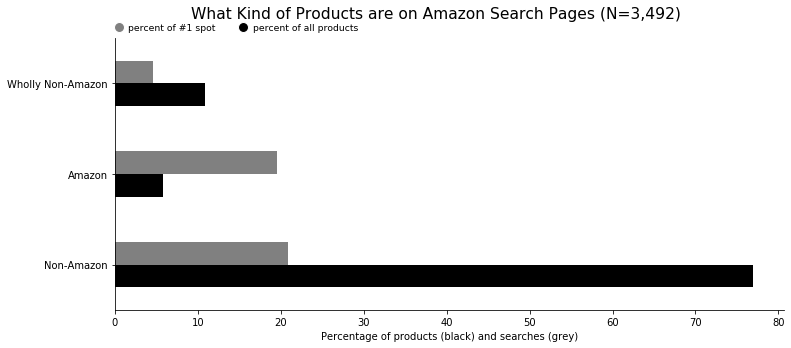

In [442]:
fig = bar_plots(res[res.Category.isin(['Amazon', 'Non-Amazon', 'Wholly Non-Amazon'])], figsize=(12,5))
fig.savefig(fig3)

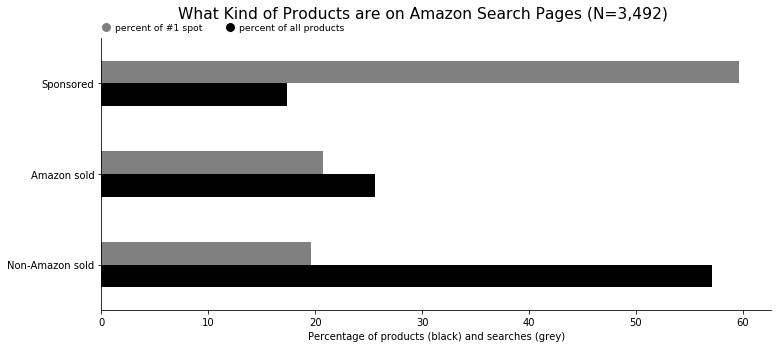

In [443]:
fig = bar_plots(res[res.Category.isin(['Amazon sold', 'Non-Amazon sold', 'Sponsored'])], figsize=(12,5))
fig.savefig(fig4)

In [63]:
cat2color = {
    'Amazon' : "#ff9900",
    'Non-Amazon' : "#ffb65f",
    'Sponsored': '#DB4437',
    'Non-Sponsored': '#ee7e6c',
    'Amazon sold': '#146eb4',
    'Amazon sold non-Amazon': '#ffb65f',
    'Non-Amazon sold': '#aabedf',
    'Wholly Non-Amazon': 'black',
    'Non-Amazon Brand and Not Amazon Sold' : '#001950'
}

In [64]:
mkr_dict = {
    'Wholly Non-Amazon': {
        'marker' : 'v',
        'color': ''
    },
    'Non-Amazon': {
        'marker' : 'o',
        'color' : ''
    }, 
    'Amazon sold' : {
        'marker': '+',
        'color' : ''
    },
    'Non-Amazon sold': {
        'marker': '+',
        'color' : ''
    },
    'Non-Amazon Brand and Not Amazon Sold' : {
        'marker': '-',
        'color': ''
    },
    'Amazon': {
        'marker': 'o',
        'color' : ''
    },
    'Sponsored' : {
        'marker' : '*',
        'color' : ''
    },
    'Amazon sold non-Amazon': {
        'marker' : '2',
        'color' : ''
    },

}

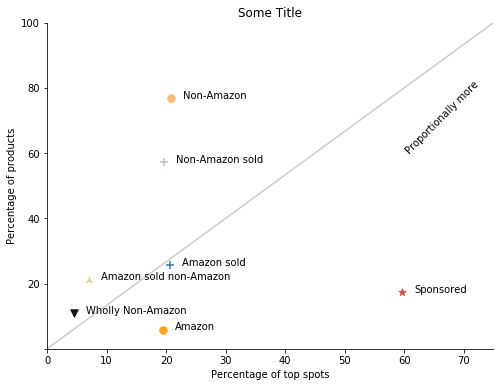

In [60]:
to_check = ['Amazon', 'Non-Amazon', 'Wholly Non-Amazon', 'Sponsored']
to_check = [
    'Amazon', 
    'Non-Amazon',
    'Amazon sold non-Amazon',
    'Non-Amazon sold',
    'Amazon sold', 
    'Wholly Non-Amazon', 
    'Sponsored'
]
# to_check = ['Amazon sold', 'Non-Amazon sold', 'Non-Amazon Brand and Not Amazon Sold']
to_plot = res[res.Category.isin(to_check)]
plt.figure(figsize=(8, 6))
plt.title("Some Title")
ax = plt.gca()
for kind in to_check:
    d = to_plot[to_plot.Category==kind]
    plt.scatter(y=d['Perc Products'],
                x=d['Perc #1 spot'],
                c=cat2color[kind],
                s=55,
                alpha=.9,
                label=kind,
                marker = mkr_dict[kind]['marker'])
    ax.annotate(kind, (d['Perc #1 spot'] + 2,
                       d['Perc Products']))

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.set_xlabel('Percentage of top spot')
ax.set_ylabel('Percentage of products')

ax.set_xlim(0, 75)
ax.set_ylim(0, 100)

ax.set_xlabel('Percentage of top spots')
ax.set_ylabel('Percentage of products')
ax.plot([0, 75], [0, 100], color='grey', alpha=.4)


ax.yaxis.get_major_ticks()[0].label1.set_visible(False)

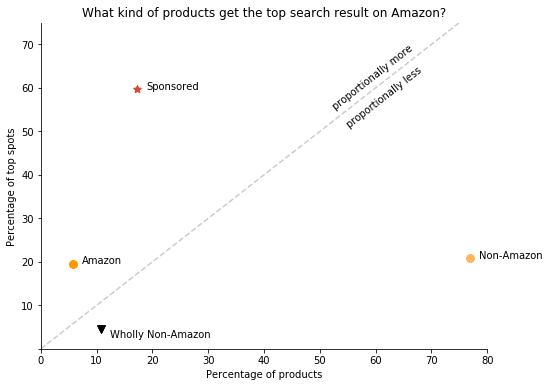

In [65]:
cats = [
    [
        'Sponsored'
    ],
    [
        'Amazon', 
        'Non-Amazon',
    ],
#     [
#         'Non-Amazon sold',
#         'Amazon sold', 
#     ],
#      [
        
#         'Amazon sold non-Amazon',
#     ],
    [ 
        'Wholly Non-Amazon', 
    ],
]
plt.figure(figsize=(8, 6))
plt.title("What kind of products get the top search result on Amazon?")
ax = plt.gca()

for i, to_check in enumerate(cats):
    fn_out = f'../data/output/animation/fig_{i}.png'
    to_plot = res[res.Category.isin(to_check)]
    
    
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    ax.set_ylabel('Percentage of top spots')
    ax.set_xlabel('Percentage of products')

    ax.set_ylim(0, 75)
    ax.set_xlim(0, 80) 
    ax.yaxis.get_major_ticks()[0].label1.set_visible(False)
    
    for kind in to_check:
        d = to_plot[to_plot.Category==kind]
        if kind in ['Non-Amazon sold', 'Wholly Non-Amazon']:
            ax.annotate(kind, (d['Perc Products'] + 1.5,
                           d['Perc #1 spot'] - 2))
        else:
            ax.annotate(kind, (d['Perc Products'] + 1.6,
                               d['Perc #1 spot']))
        for j in range(1,6):
            plt.scatter(x=d['Perc Products'],
                        y=d['Perc #1 spot'],
                        c=cat2color[kind],
                        s=55,
                        alpha=.2 * j,
                        label=kind,
                        marker = mkr_dict[kind]['marker'])
           

            fn_out = f'../data/output/animation/fig_{i}_{j:02d}.png'
            plt.savefig(fn_out);
            
ax.plot([0, 100], [0, 100],  '--', alpha=.4, color='grey')
ax.annotate("proportionally more", 
            (52, 55), rotation=38)
ax.annotate("proportionally less", 
            (54.5, 51), rotation=38)
for j in range(7, 16):
    fn_out = f'../data/output/animation/fig_{i}_{j:02d}.png'
    plt.savefig(fn_out);

In [145]:
import glob
from PIL import Image

# filepaths
fp_in = "../data/output/animation/*.png"
fp_out = "../data/output/animation/image.gif"

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=250, loop=0, optimize=True)

In [123]:
control = (df.product_order.value_counts()
    .sort_index()
    .reindex(pd.RangeIndex(1, 61))[::-1])

In [124]:
def heatmap(df, control, cmap, title, vmin=0, vmax=100):
    """Produces a heatmap of product slots"""
    amazn_label = (df
        .product_order.value_counts()
        .sort_index()
        .reindex(pd.RangeIndex(1, 61))[::-1])
 
    amazn_label = amazn_label / control * 100
    
    amazn_label_grid = amazn_label.iloc[::-1].values.reshape(15, 4)
    # amazn_label_grid = (amazn_label / amazn_label.sum() * 100).iloc[::-1].values.reshape(15, 4)

    amazn_label_grid = pd.DataFrame(amazn_label_grid)
    amazn_label_grid.index = [_ + 1 for _ in amazn_label_grid.index]
    amazn_label_grid.columns = [_ + 1 for _ in amazn_label_grid.columns]

    fig = plt.figure(figsize=(6,12))
    sns.heatmap(amazn_label_grid,
                linewidths=4,
                fmt='g',
                cmap=cmap,
                vmin=vmax,
                vmax=vmin)
    plt.title(title)
    plt.ylabel("⟵ Rows of products going down the page")
    plt.xlabel("Columns of products across the page")
    plt.yticks(rotation=0)
    
    return fig

In [125]:
amazn_label = (df_amazon_brand_
    .product_order.value_counts()
    .sort_index()
    .reindex(pd.RangeIndex(1, 61)))

amazn_label = amazn_label / control * 100
amazn_label[1] / amazn_label[1:59].mean()

3.532968501175046

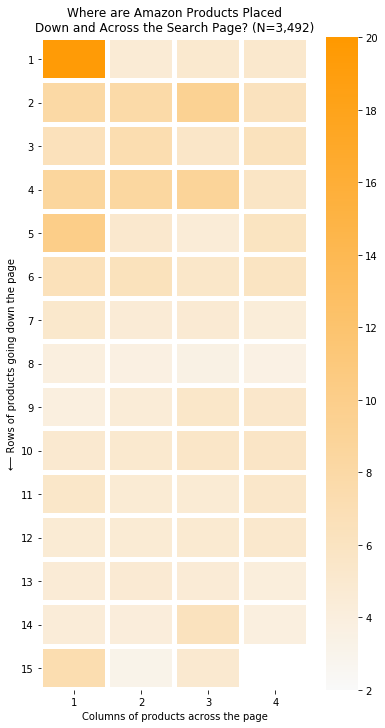

In [136]:
cmap = LinearSegmentedColormap.from_list(
    'mycmap', ['#f9f9f9', "#ff9900"]
)
fig = heatmap(
    df_amazon_brand_, control,
    cmap = LinearSegmentedColormap.from_list(None, ['#f9f9f9', "#ff9900"]),
    title=f"Where are Amazon Products Placed\nDown and Across the Search Page? (N={n_samples:,})",
    vmax=20, vmin=2
)
fig.savefig(fig5a);

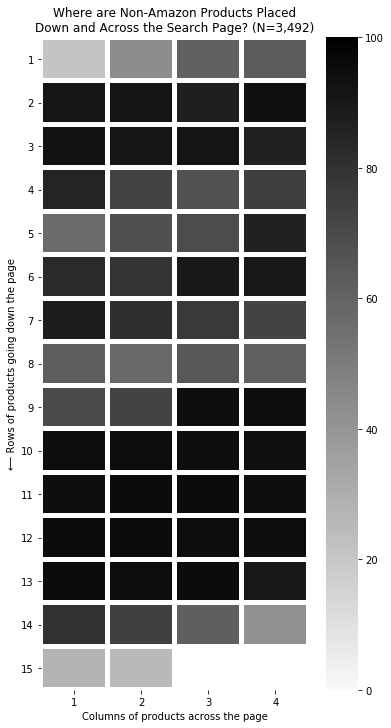

In [132]:
fig = heatmap(
    df_non_amazon, control,
    cmap = LinearSegmentedColormap.from_list(None, ['#f9f9f9', 'black']),
    title=f"Where are Non-Amazon Products Placed\nDown and Across the Search Page? (N={n_samples:,})",
)
fig.savefig(fig5b)

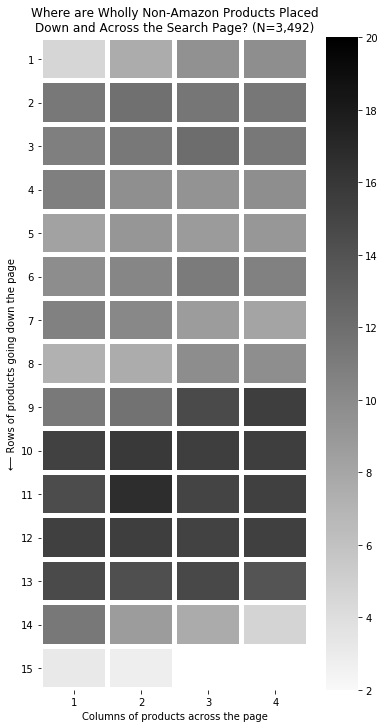

In [142]:
fig = heatmap(
    df_non_amazon_, control,
    cmap = LinearSegmentedColormap.from_list(None, ['#f9f9f9', 'black']),
    title=f"Where are Wholly Non-Amazon Products Placed\nDown and Across the Search Page? (N={n_samples:,})",
    vmax=20, vmin=2
)
fig.savefig(fig5b)

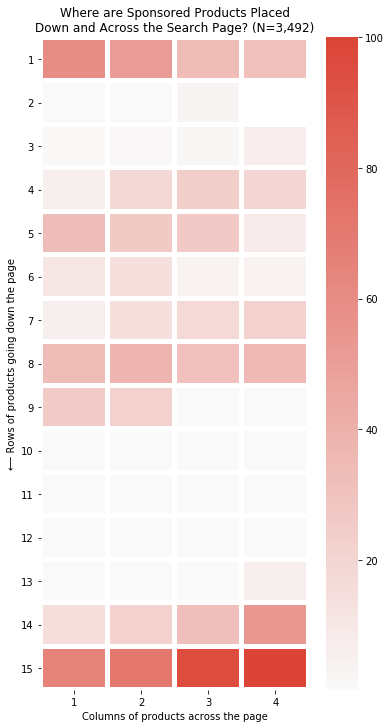

In [36]:
fig = heatmap(
    df_s, control, 
    cmap=LinearSegmentedColormap.from_list(None, ['#f9f9f9', '#DB4437']),
    title=f"Where are Sponsored Products Placed\nDown and Across the Search Page? (N={n_samples:,})"
)
fig.savefig(fig6a)

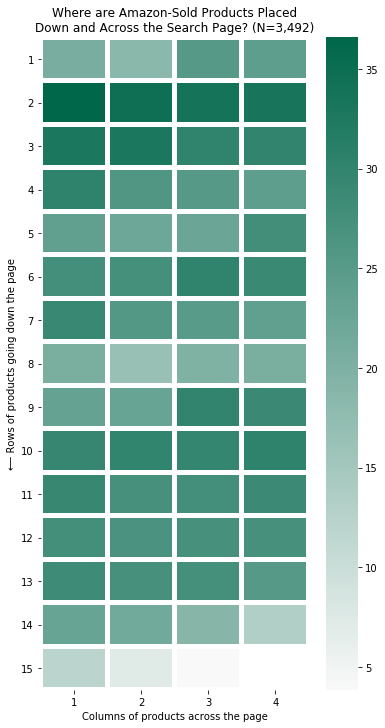

In [37]:
fig = heatmap(
    df_amazon_sold_, control, 
    cmap=LinearSegmentedColormap.from_list(None, ['#f9f9f9', '#00674b']),
    title=f"Where are Amazon-Sold Products Placed\nDown and Across the Search Page? (N={n_samples:,})"
)
fig.savefig(fig6b)

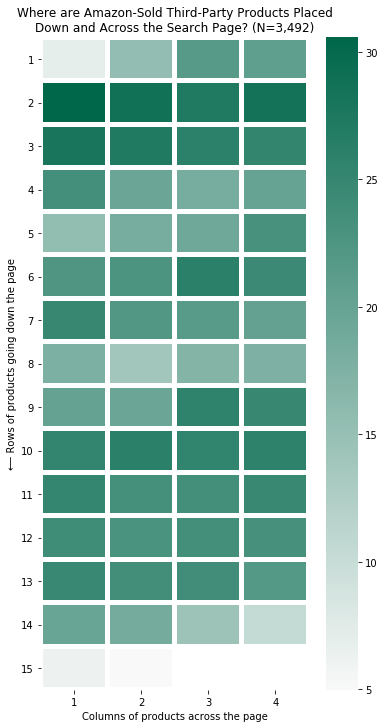

In [92]:
fig = heatmap(
    df_non_amazon_sold_by_amazon_, control, 
    cmap=LinearSegmentedColormap.from_list(None, ['#f9f9f9', '#00674b']),
    title=f"Where are Amazon-Sold Third-Party Products Placed\nDown and Across the Search Page? (N={n_samples:,})"
)

In [ ]:
fig = heatmap(
    df_amazon_sold_, control, 
    cmap=LinearSegmentedColormap.from_list(None, ['#f9f9f9', '#00674b']),
    title=f"Where are Amazon-Sold Products Placed\nDown and Across the Search Page? (N={n_samples:,})"
)
fig.savefig(fig6b)

In [38]:
# summary statisics

In [39]:
unique_products = df.drop_duplicates('asin')
n_unique_products = unique_products.asin.nunique()

In [40]:
# what percentage of products are amazon
len(unique_products[unique_products.asin.isin(amazon_asin)]) / n_unique_products

0.04693525431545134

In [36]:
## Not Clearly Labelled

In [41]:
# How many asins are Featured from our brands
(df[df.is_featured_brand == True].asin.nunique() / 
df[df.asin.isin(amazon_asin)].asin.nunique())

0.26088429612061664

In [113]:
# How many asins are Featured from our brands
(len(df[df.is_featured_brand == True]) / 
len(df[df.asin.isin(amazon_asin)]))

0.1962855382448728

In [34]:
amazon_missed_all = '|'.join([
    'amazon basics',
    'amazon essentials',
    'whole foods market',
    'amazon commercial',
    'amazon collection',
    'amazon fresh',
    'amazon elements',
    'amazonbasics'
    '365 everyday value',
    'amazon exclusive',
    'amazon us exclusive',
    'amazon brand'
])

amazon_missed = '|'.join([
    'amazon basics',
    'amazon essentials',
#     'amazon exclusive',
#     'amazon us exclusive',
#     'amazon brand'
    'whole foods market',
    'amazon commercial',
    'amazon collection',
    'amazon fresh',
    'amazon elements',
    'amazonbasics'
    '365 everyday value',
])

amazon_disclaimer = '|'.join([
    'amazon exclusive',
    'amazon us exclusive',
    'amazon brand'
])

In [35]:
# How many contain a disclaimer
(df[
  ((df.is_featured_brand) | 
   (df.product_name.str.contains(amazon_disclaimer, case=False))) &
  (df.asin.isin(amazon_asin))
].asin.nunique() / 

 df[df.asin.isin(amazon_asin)].asin.nunique())

0.4204641707606302

In [36]:
# how many items contains a name with known brand
(df[
  (df.product_name.str.contains(amazon_missed, case=False)) &
  (df.asin.isin(amazon_asin))
].asin.nunique() / 

 df[df.asin.isin(amazon_asin)].asin.nunique())

0.2475012705404032

In [37]:
# How many do not contain a disclaimer
1- (df[
  ((df.product_name.str.contains(amazon_missed_all, case=False)) | 
   (df.is_featured_brand)) &
  (df.asin.isin(amazon_asin))
].asin.nunique() / 

 df[df.asin.isin(amazon_asin)].asin.nunique())

0.4089446044384212

In [38]:
# perc of top amazon products with a "featured from our brands" tag
(df[
    (df.is_featured_brand) &
    (df.asin.isin(amazon_asin)) &
    (df.product_order == 1)
].search_term.nunique()) / df[(df.asin.isin(amazon_asin)) & (df.product_order == 1)].search_term.nunique()

0.8387978142076503

In [39]:
df.iloc[0]

asin                                                                B086VR2KY8
product_name                 All-New Toshiba 50LF621U21 50-inch Smart 4K UH...
stars                                                                      4.6
reviews                                                                   5282
brand                                                                      NaN
product_url                  /gp/slredirect/picassoRedirect.html/ref=pa_sp_...
is_prime                                                                  True
is_fresh                                                                 False
is_sponsored                                                             False
is_featured_brand                                                         True
is_amazons_choice                                                        False
is_best_seller                                                           False
product_order                                       

In [40]:
# perc of top amazon products with a known brand
(df[
    (df.product_name.str.contains(amazon_missed_all, case=False)) &
    (df.asin.isin(amazon_asin)) &
    (df.product_order == 1)
].search_term.nunique()) / df[(df.asin.isin(amazon_asin)) & (df.product_order == 1)].search_term.nunique()

0.43306010928961747

In [41]:
# perc of top amazon products with a "featured from our brands" tag or known brand
(df[
    ((df.product_name.str.contains(amazon_missed_all, case=False)) | 
    (df.is_featured_brand)) &
    (df.asin.isin(amazon_asin)) &
    (df.product_order == 1)
].search_term.nunique()) / df[(df.asin.isin(amazon_asin)) & (df.product_order == 1)].search_term.nunique()

0.9221311475409836

In [50]:
# perc of top amazon products with a "featured from our brands" tag or known brand
(df[
    ((~df.product_name.str.contains(amazon_missed_all, case=False)) | 
    (df.is_featured_brand == False)) &
    (~df.asin.isin(amazon_asin)) &
    (df.product_order == 1)
][['asin', 'product_name']]).to_csv('../data/asins_top_products_not_labelled_but_are_amazon.csv', index=False)

In [252]:
0.9221311475409836 - 0.8387978142076503

0.08333333333333326

In [254]:
1 - 0.9221311475409836

0.07786885245901642

## Bootstrap
https://codingdisciple.com/bootstrap-hypothesis-testing.html

In [72]:
def multi_bootstrap(i, n_top=1):
    """
    Takes a sample of searches with random seed `i`, shuffles each search, 
    and checks
    """
    bootstrap = resample(searches, replace=True, n_samples=n_size, random_state=i)
    df_ = df.sample(frac=1, random_state=i)
    amazon_hits = []
    no_amazon_hits = []
    sp_hits = []
    
    # check each shuffled search term
    for search_term in bootstrap:
        result = df_[df_.search_term == search_term]
        # get the n top
        result = result.iloc[:n_top]
        result_non_spon = result[result.is_sponsored != True]
        
        hits_a = result_non_spon[result_non_spon.is_amazon == True]
        hits_na = result_non_spon[result_non_spon.is_amazon != True]
        hits_sp = result[result.is_sponsored == True]
        
        amazon_hits.append(len(hits_a.head(1)))
        no_amazon_hits.append(len(hits_na.head(1)))
        sp_hits.append(len(hits_sp.head(1)))
        
    avg_amazon = np.mean(amazon_hits)
    avg_no_amazon = np.mean(no_amazon_hits)
    avg_sponsored = np.mean(sp_hits)
    
    return {
        'amazon': avg_amazon,
        'no_amazon': avg_no_amazon,
        'sponsored': avg_sponsored
    }

def multi_bootstrap_4(i):
    return multi_bootstrap(i, n_top=4)

In [73]:
def confidence_interval(stats, alpha=.95):
    """
    Gets the upper and lower bounds with a `alpha` percent confidence interval
    """
    p = ((1.0 - alpha) / 2.0) * 100
    lower = np.percentile(stats, p)
    upper = np.percentile(stats, 100 - p)
    return lower * 100, upper * 100

In [74]:
searches = df.search_term.unique()
len(searches)

3492

In [237]:
n_bootstraps = 500
n_size = 1000
n_top = 4

In [240]:
data_bootstrap = []
with Pool(processes=12) as pool:
    for record in tqdm(pool.imap_unordered(multi_bootstrap, 
                                           range(n_bootstraps)), 
                       total=n_bootstraps):
        data_bootstrap.append(record)
df_bootstrap = pd.DataFrame(data_bootstrap)

100%|██████████| 500/500 [10:02<00:00,  1.20s/it]


In [241]:
df_bootstrap

,amazon,no_amazon,sponsored
0,0.072,0.740,0.188
1,0.077,0.742,0.181
2,0.063,0.758,0.179
3,0.067,0.742,0.191
4,0.060,0.769,0.171
...,...,...,...
495,0.058,0.776,0.166
496,0.076,0.752,0.172
497,0.049,0.778,0.173
498,0.050,0.772,0.178


In [281]:
for col in ['amazon', 'no_amazon', 'sponsored']:
    print(col)
    print(df_bootstrap[col].mean() * 100)
    lower, upper = confidence_interval(df_bootstrap[col])
    print(lower, upper)

amazon
6.439399999999999
4.847500000000002 8.452499999999999
no_amazon
76.2032
73.2 79.3
sponsored
17.357400000000002
14.799999999999999 20.1525


### What are the chances?
We would not expect Amazon products to be so prominently placed at the top of the page given the relatively small selection of availble products.

To test this, we use took 500 sub-samples (of 1000 searches each) from our observed data (called bootstrapping), shuffled the order of products, and calculated the average percentage of searches where the newly assigned top spot would be taken by an Amazon, non-Amazon or sponsored product.

Given a 95 percent confidence interval, we found that Amazon products took the top spot between 4.8 and 8.5 percent of searches, non-Amazon products between 73.2 and 79.3 percent of searches and sponsored products between 14.8 and 20.2 percent of searches. These rates differ greatly from the #1 spot from our observed data, and are more closely aligned with the percentage of products available for each of the categories.

In [280]:
data_bootstrap_4 = []
with Pool(processes=12) as pool:
    for record in tqdm(pool.imap_unordered(multi_bootstrap_4, 
                                           range(n_bootstraps)), 
                       total=n_bootstraps):
        data_bootstrap_4.append(record)

df_bootstrap_4 = pd.DataFrame(data_bootstrap_4)

100%|██████████| 500/500 [10:27<00:00,  1.25s/it]


In [282]:
for col in ['amazon', 'no_amazon', 'sponsored']:
    print(col)
    print(df_bootstrap_4[col].mean() * 100)
    lower, upper = confidence_interval(df_bootstrap_4[col])
    print(lower, upper)

amazon
20.950400000000002
18.4 23.9
no_amazon
99.24300000000001
98.6 99.70000000000002
sponsored
52.96680000000001
49.1 56.39999999999999


## More Stars and reviews?

In [52]:
data = []
for st, _df in tqdm(df[df.is_sponsored == False].groupby("search_term")):
    _df.sort_values(by='product_order')
    amzn = _df[_df.asin.isin(amazon_asin)]
    non_amzn = _df[~_df.asin.isin(amazon_asin)]
    wnon_amzn =_df[
        (~_df.asin.isin(amazon_asin)) &
        (_df.is_sold_by_amazon == False) &
        (_df.is_fresh == False) &
        (_df.is_prime == False)
    ]
    
    if not amzn.empty:
        top_amazon =  amzn.product_order.iloc[0]
        amazon_star = amzn.stars.iloc[0]
        amazon_review = amzn.reviews.iloc[0]
    else:
        top_amazon = np.nan
        amazon_star = np.nan
        amazon_review = np.nan
        
    if not non_amzn.empty:    
        top_non_amazon_brand = non_amzn.product_order.iloc[0]
        non_amazon_star = non_amzn.stars.iloc[0]
        non_amazon_review = non_amzn.reviews.iloc[0]
    else:
        top_non_amazon = np.nan
        non_amazon_star = np.nan
        non_amazon_review = np.nan
        
    if not wnon_amzn.empty:
        top_wnon_amazon = wnon_amzn.product_order.iloc[0]
        wnon_amazon_star = wnon_amzn.stars.iloc[0]
        wnon_amazon_review = wnon_amzn.reviews.iloc[0]
    
    else:
        top_wnon_amazon = np.nan
        wnon_amazon_star = np.nan
        wnon_amazon_review = np.nan
    record = {
        "search_term": st,
        "position_first_amazon": top_amazon,
        "position_first_non_amazon": top_non_amazon_brand,
        "position_first_wholly_non_amazon": top_wnon_amazon,
        
        "amazon_stars": amazon_star,
        "amazon_reviews": amazon_review,
        
        "non_amazon_stars": non_amazon_star,
        "non_amazon_reviews": non_amazon_review,
        
        "wnon_amazon_stars": wnon_amazon_star,
        "wnon_amazon_reviews": wnon_amazon_review,
    }
    data.append(record)

100%|██████████| 3492/3492 [04:12<00:00, 13.81it/s]


In [53]:
df_compare = pd.DataFrame(data)

In [54]:
len(df_compare[df_compare.position_first_amazon < df_compare.position_first_non_amazon]) / len(df_compare)

0.22880870561282932

In [69]:
df_compare[
    df_compare.position_first_amazon < df_compare.position_first_non_amazon
].apply(
    lambda x:
    x['amazon_stars'] > x['non_amazon_stars'],
    axis=1
).value_counts(normalize=True)

False    0.653317
True     0.346683
dtype: float64

In [70]:
# how many Amazon products have more reivews than the
df_compare[
    (df_compare.position_first_amazon < df_compare.position_first_non_amazon) &
    (~df_compare.non_amazon_reviews.isnull())
].apply(
    lambda x:
    x['amazon_reviews'] > x['non_amazon_reviews'],
    axis=1
).value_counts(normalize=True)

False    0.509579
True     0.490421
dtype: float64

In [72]:
# how many Amazon products have more reivews than the
df_compare[
    (df_compare.position_first_amazon < df_compare.position_first_non_amazon) &
    (~df_compare.non_amazon_reviews.isnull())
].apply(
    lambda x:
    (x['amazon_reviews'] < x['non_amazon_reviews']) and 
    (x['amazon_stars'] < x['non_amazon_stars']),
    axis=1
).value_counts(normalize=True)

False    0.798212
True     0.201788
dtype: float64

In [45]:
# duplicates from sponsorship
asins_by_search = df[df.is_sponsored == False].groupby('search_term').asin.value_counts()

In [46]:
# perc_searches_dupluicate_asin
asins_by_search[asins_by_search > 1].index.get_level_values(0).nunique() / df.search_term.nunique()

0.09221076746849943

In [47]:
# how many of these duplicates are Amazon products?
duplicate_asin = asins_by_search[asins_by_search > 1].index.get_level_values(1)
len([_ for _ in duplicate_asin if _ in amazon_asin]) / len(duplicate_asin)

1.0

In [94]:
asins_by_search = df[df.is_amazon == False].groupby('search_term').asin.value_counts()

In [97]:
# perc_searches_dupluicate_asin
asins_by_search[asins_by_search > 1].index.get_level_values(0).nunique() / df.search_term.nunique()

0.7422680412371134

## Supplementary dataset

In [47]:
df_generic.search_term.nunique()

1217

In [445]:
table_generic = calculate_table_not_unique(df_generic, amazon_asin)
table_generic

,Category,Perc Products,Perc #1 spot,Perc first row
0,Wholly Non-Amazon,4.143634,1.068200,5.012325
1,Amazon,8.225208,24.897288,35.332786
2,Non-Amazon,73.530388,10.764174,54.478225
3,Non-Amazon Brand and Not Amazon Sold,34.315240,5.834018,33.771569
4,Amazon product not featured,7.200485,4.108463,16.516023
5,Sponsored,18.244404,64.338537,84.223500
6,Amazon sold,25.382828,21.857025,45.193098
7,Amazon sold non-Amazon,18.771198,3.451109,23.007395
8,Non-Amazon sold,56.372768,13.804437,48.808546
9,Amazon Shipped,77.500830,34.511093,70.008217


In [446]:
table_top = calculate_table_not_unique(df_top, amazon_asin)
table_top

,Category,Perc Products,Perc #1 spot,Perc first row
0,Wholly Non-Amazon,10.852965,4.553265,14.977090
1,Amazon,5.801081,19.530355,24.770905
2,Non-Amazon,76.880992,20.819015,63.516609
3,Non-Amazon Brand and Not Amazon Sold,54.902578,13.545246,46.048110
4,Amazon product not featured,4.611964,1.947308,8.218786
5,Sponsored,17.317926,59.650630,75.286369
6,Amazon sold,25.549500,20.733104,44.186712
7,Amazon sold non-Amazon,21.142300,7.016037,30.670103
8,Non-Amazon sold,57.132573,19.616266,51.718213
9,Amazon Shipped,71.672870,35.595647,70.217640


In [447]:
table_top.set_index('Category').apply(proportion, axis=1)

Category
Wholly Non-Amazon                       2.4x less
Amazon                                  3.4x more
Non-Amazon                              3.7x less
Non-Amazon Brand and Not Amazon Sold    4.1x less
Amazon product not featured             2.4x less
Sponsored                               3.4x more
Amazon sold                             1.2x less
Amazon sold non-Amazon                  3.0x less
Non-Amazon sold                         2.9x less
Amazon Shipped                          2.0x less
Amazon Shipped non-Amazon               4.1x less
dtype: object

In [448]:
table_generic.set_index('Category').apply(proportion, axis=1)

Category
Wholly Non-Amazon                       3.9x less
Amazon                                  3.0x more
Non-Amazon                              6.8x less
Non-Amazon Brand and Not Amazon Sold    5.9x less
Amazon product not featured             1.8x less
Sponsored                               3.5x more
Amazon sold                             1.2x less
Amazon sold non-Amazon                  5.4x less
Non-Amazon sold                         4.1x less
Amazon Shipped                          2.2x less
Amazon Shipped non-Amazon               7.2x less
dtype: object

In [419]:
n_offers = 10
n_applicants = 1000
offer_rate = .2
applicant_rate = .05

1 / ((offer_rate * n_offers) / (applicant_rate* n_applicants))

25.0

In [409]:
20 / 5

4.0

In [410]:
20 / 8.5

2.3529411764705883

In [414]:
n_offers = 10
n_applicants = 1000
offer_rate = .2
applicant_rate = .05

In [415]:
offer_rate / applicant_rate

4.0

In [420]:
n_offers = df.search_term.nunique()
n_applicants = df.asin.nunique()
offer_rate = .2
applicant_rate = .05

In [425]:
1/ ((offer_rate * n_offers) / (applicant_rate* n_applicants))

144.06529209621993

In [422]:
n_offers = df.search_term.nunique()
n_applicants = df.asin.nunique()
offer_rate = .2
applicant_rate = .80

In [423]:
1 / ((offer_rate * n_offers) / (applicant_rate* n_applicants))

144.06529209621993

In [342]:
df[df.is_amazon == True].asin.nunique() / df[(df.product_order == 1) & (df.is_amazon == True)].search_term.nunique()

8.064207650273223

In [343]:
df[df.is_amazon != True].asin.nunique() / df[(df.product_order == 1) & (df.is_amazon != True)].search_term.nunique()

43.42971014492753

In [337]:
df[(df.product_order == 1) & (df.is_amazon == True)].search_term.nunique()

732

In [449]:
table_diff = table_generic.set_index('Category').subtract(
    table_top.set_index('Category'))

In [453]:
comparison = pd.concat([
    table_top[['Category', 'Perc Products',  'Perc #1 spot', 'Perc first row']].set_index('Category'), 
    table_generic[['Category','Perc Products',  'Perc #1 spot', 'Perc first row']].set_index('Category'),
], axis=1, keys=["top", "generic"])

In [454]:
comparison = comparison.swaplevel(0, 1, 1).sort_index(1)

In [455]:
comparison

Perc #1 spot            Perc Products  \
                                          generic        top       generic   
Category                                                                     
Wholly Non-Amazon                        1.068200   4.553265      4.143634   
Amazon                                  24.897288  19.530355      8.225208   
Non-Amazon                              10.764174  20.819015     73.530388   
Non-Amazon Brand and Not Amazon Sold     5.834018  13.545246     34.315240   
Amazon product not featured              4.108463   1.947308      7.200485   
Sponsored                               64.338537  59.650630     18.244404   
Amazon sold                             21.857025  20.733104     25.382828   
Amazon sold non-Amazon                   3.451109   7.016037     18.771198   
Non-Amazon sold                         13.804437  19.616266     56.372768   
Amazon Shipped                          34.511093  35.595647     77.500830   
Amazon Shipped non-Amazon                9.695974  16.265750     69.386754   

                                                Perc first row             
                                            top        generic        top  
Category                                                                   
Wholly Non-Amazon                     10.852965       5.012325  14.977090  
Amazon                                 5.801081      35.332786  24.770905  
Non-Amazon                            76.880992      54.478225  63.516609  
Non-Amazon Brand and Not Amazon Sold  54.902578      33.771569  46.048110  
Amazon product not featured            4.611964      16.516023   8.218786  
Sponsored                             17.317926      84.223500  75.286369  
Amazon sold                           25.549500      45.193098  44.186712  
Amazon sold non-Amazon                21.142300      23.007395  30.670103  
Non-Amazon sold                       57.132573      48.808546  51.718213  
Amazon Shipped                        71.672870      70.008217  70.217640  
Amazon Shipped non-Amazon             66.027494      52.917009  58.705613

In [466]:
comparison[
    ~comparison.index.isin(['Non-Amazon Brand and Not Amazon Sold'])
].round(1).to_csv(table1)

## Sankey

In [459]:
df_ns

,asin,product_name,stars,reviews,brand,product_url,is_prime,is_fresh,is_sponsored,is_featured_brand,...,has_third_party_sellers,product_by_amazon,our_brands_carousel,ads,suggestions,n_ads,is_amazon,is_sold_by_amazon,is_shipped_by_amazon,is_shipped_by_amazon_TRUE
0,B086VR2KY8,All-New Toshiba 50LF621U21 50-inch Smart 4K UH...,4.6,5282,NaN,/gp/slredirect/picassoRedirect.html/ref=pa_sp_...,True,False,False,True,...,False,False,False,[],"['B086VR2KY8', 'B086VR2KY8', 'B086VR2KY8', 'B0...",0.0,True,False,False,True
1,B086VRR9K9,All-New Insignia NS-50DF710NA21 50-inch Smart ...,4.6,8569,NaN,/gp/slredirect/picassoRedirect.html/ref=pa_sp_...,True,False,False,True,...,False,False,False,[],"['B086VRR9K9', 'B086VRR9K9', 'B086VRR9K9', 'B0...",0.0,True,False,False,True
2,B08DHFX4FV,"TCL 4K Smart LED TV, 50"" (50S435)",4.6,1314,NaN,/TCL-4K-Smart-LED-50S435/dp/B08DHFX4FV/ref=sr_...,True,False,False,False,...,True,False,False,"[b'<div id=""ape_Detail_ams-detail-right-v2_des...","['B08DHFX4FV', 'B08DHFX4FV', 'B08DHFX4FV', 'B0...",4.0,False,True,True,True
3,B086VR2KY8,All-New Toshiba 50LF621U21 50-inch Smart 4K UH...,4.6,5282,NaN,/All-New-Toshiba-50LF621U21-50-inch-Vision/dp/...,True,False,False,False,...,False,False,False,[],"['B086VR2KY8', 'B086VR2KY8', 'B086VR2KY8', 'B0...",0.0,True,False,False,True
4,B086VRR9K9,All-New Insignia NS-50DF710NA21 50-inch Smart ...,4.6,8569,NaN,/All-New-Insignia-NS-50DF710NA21-50-inch-Smart...,True,False,False,False,...,False,False,False,[],"['B086VRR9K9', 'B086VRR9K9', 'B086VRR9K9', 'B0...",0.0,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248929,B00VXKJIAO,00 Antimo Caputo Pasta & Gnocchi Flour 5 Lb Bu...,4.6,260,NaN,/Antimo-Caputo-Pasta-Gnocchi-Flour/dp/B00VXKJI...,False,False,False,False,...,True,False,False,"[b'<div id=""ape_Detail_ams-detail-right-v2_des...","['B00VXKJIAO', 'B00VXKJIAO', 'B00VXKJIAO', 'B0...",4.0,False,False,True,True
248930,B08JF1GH32,Antimo Caputo Classic All-Purpose Flour - 2 x ...,5.0,3,NaN,/Antimo-Caputo-Classic-All-Purpose-Flour/dp/B0...,True,False,False,False,...,False,False,False,"[b'<div id=""ape_Detail_ams-detail-right-v2_des...","['B08JF1GH32', 'B08JF1GH32', 'B08JF1GH32', 'B0...",4.0,False,False,True,True
248931,B088X3T87B,Mulino Caputo 00 Americana Flour - 10 Lb Repac...,4.9,25,NaN,/Mulino-Caputo-Americana-Flour-BrickOvenBaker/...,True,False,False,False,...,True,False,True,"[b'<div id=""ape_Detail_ams-detail-right-v2_des...","['B088X3T87B', 'B088X3T87B', 'B088X3T87B', 'B0...",4.0,False,False,False,True
248932,B088XT5RLB,Antimo Caputo Blue Pizzeria Flour 55 LB Blue B...,5.0,6,NaN,/Antimo-Caputo-Blue-Pizzeria-Flour/dp/B088XT5R...,True,False,False,False,...,True,False,True,"[b'<div id=""ape_Detail_ams-detail-right-v2_des...","['B088XT5RLB', 'B088XT5RLB', 'B088XT5RLB', 'B0...",4.0,False,True,True,True


In [465]:
print(json.dumps({
    "nodes":[
        {"name":"All Products","node":0},
        {"name":"Sponsored","node":1},   
        {"name":"Non-Sponsored","node":2},   
        {"name":"Sold by Amazon","node":3},
        {"name":"Not Sold by Amazon","node":4},
        {"name":"Amazon Product","node":5},
        {"name":"Not Amazon Product","node":6}
    ],
    "links":[
        {"source":0,"target":1,"value":len(df_s)},
        {"source":0,"target":2,"value":len(df_ns)},  
        {"source":2,"target":3,"value":len(df_amazon_sold_)},
        {"source":2,"target":4,"value":len(df_not_amazon_sold_)},    
        {"source":3,"target":5,"value":len(df_amazon_sold_[df_amazon_sold_.asin.isin(amazon_asin)])},
        {"source":3,"target":6, "value":len(df_amazon_sold_[~df_amazon_sold_.asin.isin(amazon_asin)])},
        {"source":4,"target":5,"value":len(df_not_amazon_sold_[df_not_amazon_sold_.asin.isin(amazon_asin)])},
        {"source":4,"target":6,"value":len(df_not_amazon_sold_[~df_not_amazon_sold_.asin.isin(amazon_asin)])},
    ]
}))

{"nodes": [{"name": "All Products", "node": 0}, {"name": "Sponsored", "node": 1}, {"name": "Non-Sponsored", "node": 2}, {"name": "Sold by Amazon", "node": 3}, {"name": "Not Sold by Amazon", "node": 4}, {"name": "Amazon Product", "node": 5}, {"name": "Not Amazon Product", "node": 6}], "links": [{"source": 0, "target": 1, "value": 32477}, {"source": 0, "target": 2, "value": 155057}, {"source": 2, "target": 3, "value": 47914}, {"source": 2, "target": 4, "value": 107143}, {"source": 3, "target": 5, "value": 8265}, {"source": 3, "target": 6, "value": 39649}, {"source": 4, "target": 5, "value": 2614}, {"source": 4, "target": 6, "value": 104529}]}


## Error check

In [128]:
check_asin = df[
    (df.is_amazon == True) &
    (df.is_sold_by_amazon == False)
]

In [129]:
fn_amazon = '../data/intermediary/amazon_private_label.csv.gz'

In [42]:
df_amazon

,asin,product_name,stars,reviews,brand,product_url,is_prime,is_fresh,is_sponsored,is_featured_brand,...,sold_by,has_third_party_sellers,product_by_amazon,our_brands_carousel,ads,suggestions,n_ads,is_amazon,is_sold_by_amazon,is_shipped_by_amazon
0,B086VR2KY8,All-New Toshiba 50LF621U21 50-inch Smart 4K UH...,4.6,5282,NaN,/gp/slredirect/picassoRedirect.html/ref=pa_sp_...,True,False,False,True,...,Best Buy,False,False,False,[],"['B086VR2KY8', 'B086VR2KY8', 'B086VR2KY8', 'B0...",0.0,True,False,False
1,B086VRR9K9,All-New Insignia NS-50DF710NA21 50-inch Smart ...,4.6,8569,NaN,/gp/slredirect/picassoRedirect.html/ref=pa_sp_...,True,False,False,True,...,NaN,False,False,False,[],"['B086VRR9K9', 'B086VRR9K9', 'B086VRR9K9', 'B0...",0.0,True,False,False
3,B086VR2KY8,All-New Toshiba 50LF621U21 50-inch Smart 4K UH...,4.6,5282,NaN,/All-New-Toshiba-50LF621U21-50-inch-Vision/dp/...,True,False,False,False,...,Best Buy,False,False,False,[],"['B086VR2KY8', 'B086VR2KY8', 'B086VR2KY8', 'B0...",0.0,True,False,False
4,B086VRR9K9,All-New Insignia NS-50DF710NA21 50-inch Smart ...,4.6,8569,NaN,/All-New-Insignia-NS-50DF710NA21-50-inch-Smart...,True,False,False,False,...,NaN,False,False,False,[],"['B086VRR9K9', 'B086VRR9K9', 'B086VRR9K9', 'B0...",0.0,True,False,False
6,B0872FYTWS,All-New Toshiba 32LF221U21 32-inch Smart HD 72...,4.7,10895,NaN,/gp/slredirect/picassoRedirect.html/ref=pa_sp_...,True,False,False,True,...,NaN,False,False,False,[],"['B0872FYTWS', 'B0872FYTWS', 'B0872FYTWS', 'B0...",0.0,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248918,B086VR2KY8,All-New Toshiba 50LF621U21 50-inch Smart 4K UH...,4.6,5282,NaN,/gp/slredirect/picassoRedirect.html/ref=pa_sp_...,True,False,False,True,...,Best Buy,False,False,False,[],"['B086VR2KY8', 'B086VR2KY8', 'B086VR2KY8', 'B0...",0.0,True,False,False
248923,B0874XJYW8,All-New Toshiba 43LF621U21 43-inch Smart 4K UH...,4.6,5282,NaN,/gp/slredirect/picassoRedirect.html/ref=pa_sp_...,True,False,False,True,...,NaN,False,False,False,[],"['B0874XJYW8', 'B0874XJYW8', 'B0874XJYW8', 'B0...",0.0,True,False,False
248926,B086VR2KY8,All-New Toshiba 50LF621U21 50-inch Smart 4K UH...,4.6,5282,NaN,/All-New-Toshiba-50LF621U21-50-inch-Vision/dp/...,True,False,False,False,...,Best Buy,False,False,False,[],"['B086VR2KY8', 'B086VR2KY8', 'B086VR2KY8', 'B0...",0.0,True,False,False
248928,B086VSTFYP,All-New Insignia NS-55DF710NA21 55-inch Smart ...,4.7,1609,NaN,/gp/slredirect/picassoRedirect.html/ref=pa_sp_...,False,False,False,True,...,NaN,False,False,False,[],"['B086VSTFYP', 'B086VSTFYP', 'B086VSTFYP', 'B0...",0.0,True,False,False


In [45]:
value_counts(df_amazon, 'source')

,count,percentage
our brands filtered search result,68671,0.499716
our brands API,66476,0.483743
text search,780,0.005676
featured from our brands carousel,684,0.004977
best selling Amazon devices,505,0.003675
featured from our brands tag,304,0.002212


In [139]:
df_amazon[df_amazon.asin.isin(check_asin.asin)].source.value_counts()

our brands API                       697
text search                          247
our brands filtered search result    222
featured from our brands tag          78
best selling Amazon devices           19
featured from our brands carousel      6
Name: source, dtype: int64

In [143]:
value_counts(check_asin.drop_duplicates('asin').merge(
    df_amazon, on='asin', how='left'
), 'source', dropna=False)

,count,percentage
our brands API,697,0.549251
text search,247,0.194641
our brands filtered search result,222,0.174941
featured from our brands tag,78,0.061466
best selling Amazon devices,19,0.014972
featured from our brands carousel,6,0.004728


In [158]:
to_check = check_asin.drop_duplicates('asin').merge(
    df_amazon, on='asin', how='left'
)

In [153]:
to_check= to_check[to_check.source == 'text search']

In [154]:
to_check.sold_by.value_counts(dropna=False)

NaN                   241
Exposed Skin Care       1
BalsamHill              1
VM Express              1
Real Merch UK           1
Speedy Fulfillment      1
psf_entertainment       1
Name: sold_by, dtype: int64

In [157]:
to_check.to_csv('../data/intermediary/spot_check/text_search_asins_2021-5-4.csv', index=False)

In [159]:
to_check.to_csv('../data/intermediary/spot_check/all_outlier_asins_2021-5-4.csv', index=False)

In [242]:
"B07MC98SZH" in amazon_asin

False

In [47]:
len(df[df.is_amazon == True]) / len(df)

0.06012874280698332

In [96]:
__df_search = df_search[
    (df_search.search_term.isin(searches_with_amazon_brands)) & 
    (df_search.search_term.isin(top_searches))
].merge(df_products, how='left')

In [97]:
__df_search.product_type.value_counts()

regular_placement            187534
editorial_recs_carousel        8917
sponsored_banner               6587
featured_brands_carousel       4558
regular_placement__missed      1388
misc_carousel                   830
misc_sponsored_carousel         479
Name: product_type, dtype: int64

In [98]:
def carousel_correction(row):
    if row['product_type'] == 'featured_brands_carousel':
        return True
    else:
        return row['is_amazon']

In [99]:
__df_search["is_amazon"] = __df_search.apply(carousel_correction, axis=1)

In [100]:
[
    'editorial_recs_carousel',
    'sponsored_banner',
    'misc_carousel',
    'regular_placement__missed '
]

['editorial_recs_carousel',
 'sponsored_banner',
 'misc_carousel',
 'regular_placement__missed ']

In [102]:
calculate_table(__df_search, amazon_asin=amazon_asin)

,Category,Perc Products,Perc #1 spot,Perc first row
0,Wholly Non-Amazon,11.391891,4.553265,14.977090
1,Amazon,6.050673,19.587629,24.770905
2,Non-Amazon,78.651370,21.048110,63.631157
3,Non-Amazon Brand and Not Amazon Sold,56.219732,13.631157,46.134021
4,Amazon product not featured,5.367056,2.061856,8.247423
5,Sponsored,22.757205,66.580756,94.329897
6,Amazon sold,22.874587,21.019473,44.301260
7,Amazon sold non-Amazon,19.356839,7.302405,30.813288
8,Non-Amazon sold,61.827457,19.845361,51.890034
9,Amazon Shipped,68.736712,34.536082,69.329897


In [114]:
calculate_table(df, amazon_asin=amazon_asin)

,Category,Perc Products,Perc #1 spot,Perc first row
0,Wholly Non-Amazon,12.247851,4.553265,14.977090
1,Amazon,4.572669,19.530355,24.770905
2,Non-Amazon,82.083820,20.819015,63.516609
3,Non-Amazon Brand and Not Amazon Sold,60.298643,13.545246,46.048110
4,Amazon product not featured,3.764839,1.947308,8.218786
5,Sponsored,20.294349,59.650630,75.286369
6,Amazon sold,24.268301,20.733104,44.186712
7,Amazon sold non-Amazon,20.687928,7.016037,30.670103
8,Non-Amazon sold,62.388188,19.616266,51.718213
9,Amazon Shipped,69.935358,34.335624,69.186712


In [115]:
22.757205 - 20.294349

2.4628559999999986

In [222]:
1 / (20.819015 / 82.083820)

3.942733121619827

In [223]:
19.530355 / 4.572669

4.271106218272085

In [224]:
12.247851 / 4.553265

2.689905155970496

0    0.371760
1    4.271106
2    0.253631
3    0.224636
4    0.517235
5    2.939273
6    0.854329
7    0.339137
8    0.314423
9    0.490962
dtype: float64